In [21]:
import json
import urllib
import os
import csv

# 0. Preliminary step to get the dataset




Getting data from sharable google drive folder 

In [22]:
# link to folder: https://drive.google.com/drive/folders/18TjiltRr8CFlx0aPcLsnKBr5iyeiQxWc?usp=sharing
# upload data folder to your drive root folder 'My Drive' (It is the default folder).

In [24]:
# connect your drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')
# after running this cell, open the url that displays below from your gmail account
# copy the code that is displayed 
# paste the code into the cell below when prompted and then press enter

Mounted at /content/drive


In [25]:
folder_path = '/content/drive/My Drive/data_tm_workflow/'

In [26]:
# set the output folder in the drive (the csv files with the results of the process will be downloaded there)
# first create the empty folder in the drive
output_folder = '/content/drive/My Drive/output_tm_gensim'

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [27]:
import pandas as pd

In [28]:
files_list = os.listdir(folder_path)

In [29]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

## 1.2. Adding columns for dates, publications and filtering dataset

### 1.2.1. dates, publications


In [30]:
import re

In [31]:
# get publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

# get date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# get year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# get month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

# get day from file name
def get_day(file):
  month_match = re.findall(r'_\d{4}-\d{2}-(\d{2})_',file)
  return month_match[0]

In [32]:
sources['date'] = sources['file_name'].apply(lambda x: get_date(x))
sources['year'] = sources['file_name'].apply(lambda x: get_year(x))
sources['month'] = sources['file_name'].apply(lambda x: get_month(x))
sources['day'] = sources['file_name'].apply(lambda x: get_day(x))
sources['publication'] = sources['file_name'].apply(lambda x: get_ref(x))

In [33]:
# add publication names
def get_pub_name(pub_number):
    if (pub_number == 'sn85066408'):
        return 'L\'Italia'
    elif (pub_number == '2012271201'):
        return 'Cronaca Sovversiva'

In [34]:
sources['publication_name'] = sources['publication'].apply(lambda x: get_pub_name(x))

### 1.2.2. Filtering

In [35]:
import datetime
from datetime import timedelta, date

In [36]:
# Start from 06.06.1903 and finish 01.05.1919
date_ref_1 = date(1903,6,6)
date_ref_2 = date(1919,5,1)

In [37]:
def filter_by_date(date_item,date_ref_1,date_ref_2):
    year = re.findall(r'(\d{4})-\d{2}-\d{2}',date_item)[0]
    month = re.findall(r'\d{4}-(\d{2})-\d{2}',date_item)[0]
    day = re.findall(r'\d{4}-\d{2}-(\d{2})',date_item)[0]
    file_date = date(int(year),int(month),int(day))
    if (date_ref_1 <= file_date <= date_ref_2):
        return 'included'
    else:
        return 'not included'

In [38]:
sources['status'] = sources['date'].apply(lambda x: filter_by_date(x,date_ref_1,date_ref_2))

In [39]:
# variable containing the filtered documents
corpus_df = sources[sources['status'] == 'included'].copy().reset_index()

### 1.2.3 Adding text content

In [40]:
# read the content of the text files
def readTxtContent(fileName):
  with open(folder_path + fileName, 'r') as file:
    print(fileName)
    return ' ' + file.read().replace('\n', ' ') + ' '

In [ ]:
# add a column to the dataframe containing file content
corpus_df['file_content'] = corpus_df['file_name'].apply(lambda x: readTxtContent(x))

In [ ]:
import csv
corpus_df.to_csv(output_folder + '/documents_list.csv')

In [44]:
#if the file has already been generated, upload the file in notebook env and call it here
# corpus_df = pd.read_csv('documents_list.csv')

## 1.2 Removing stop words, punctuation, short words

In [45]:
! pip install nltk

In [46]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
# add tokenized documents in dataframe
corpus_df['tokens'] = corpus_df['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [48]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to remove all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
corpus_df['doc_prep'] = corpus_df['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [ ]:
# link to custom stop words: https://drive.google.com/file/d/1VVfW6AKPbb7_fICOG73lEgkXmmZ6BkpC/view?usp=sharing
# Upload stop words list into Colab files before proceeding with the next cells

In [49]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')
en_stopwords = stopwords.words('english')

In [50]:
stop_words = pd.read_csv('stop_words.csv')

In [51]:
stopwords = stop_words['stopword'].values.tolist()

In [52]:
# add english stop words list to custom stopwords 
stopwords.extend(en_stopwords)

In [ ]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [53]:
# add column with tokenized documents without sw
corpus_df['doc_prep_nostop'] = corpus_df['doc_prep'].apply(lambda x: [w for w in x if not w in stopwords])

In [54]:
corpus_df['doc_prep_nostop']

0      [nura, dtfip, verrmo, assioma, auanto, barba, ...
1      [saturday, january, barre, vermont, sabato, ge...
2      [annj, xii, iodio, mite, umberto, santo, costi...
3      [vili, entered, brusco, svolto, storia, partit...
4      [scoi, ietti, lez, actf, àttof, coij, peri, it...
                             ...                        
766    [ionn, imperversa, giungono, spiaggie, patria,...
767    [ass, ittc, ass, tìii, eie, alt, sss, lynn, au...
768    [num, xii, magnifico, pertinacia, levato, pean...
769    [ann, rhe, fcr, rivo, ragioni, economiche, sfa...
770    [newspapet, objection, anvo, nura, mmmmmmm, an...
Name: doc_prep_nostop, Length: 771, dtype: object

In [55]:
# set the variable to use for topic modelling (if no further options are used)
corpus_model = corpus_df['doc_prep_nostop']

In [56]:
# save the data after pre-processing in the output folder for verification of pre-processing steps
# corpus_df.to_csv(output_folder + '/corpus_df.csv')
corpus_df.to_csv(output_folder + '/corpus_df.csv')

## 1.4 Lemmatize

In [ ]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [57]:
!pip install spacy

In [58]:
!python3 -m spacy download it_core_news_sm

     |████████████████████████████████| 14.5MB 60.0MB/s 
  Created wheel for it-core-news-sm: filename=it_core_news_sm-2.2.5-cp36-none-any.whl size=14471130 sha256=9390c2ce5eedb44cd21566e2c78fe56b0b54f6ac44e9fdb9da4f94fbf4b771f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_v058md/wheels/a1/01/c2/127ab92cc5e3c7f36b5cd4bff28d1c29c313962a2ba913e720
Successfully built it-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [59]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [60]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [61]:
# takes a long time to run
# add column with lemmatized tokens - directly from the tokens as preprocessing has already been done
corpus_df['doc_lemmatized'] = corpus_df['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [62]:
# variable with lemmatized tokens
lemmatized_corpus = corpus_df['doc_lemmatized']
# the lemmatized version is not used in this example

# 2. Topics with LDA

In [63]:
#Gensim installation
! pip install gensim

In [64]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Creating the dictionary, optional filtering of extreme values

In [65]:
# if you use lemmatized version replace "corpus_model" by lemmatized_corpus
id2word = corpora.Dictionary(corpus_model)

In [66]:
id2word.filter_extremes(no_below=5)

### 2.1.2 Bag of words

In [67]:
corpus = [id2word.doc2bow(text) for text in corpus_model]

## 2.2 LDA

### 2.2.1. Option 1: Train a model without coherence calculation



In [69]:
# set the nr of topics
num_topics = 7

In [70]:
# faster preset (hypothetically less accurate)
# model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, eval_every = None)
# slower preset (hypothetically more accurate)
# model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=1000, iterations = 200, passes = 10, eval_every = None)
# slowest preset (hypothetically even more accurate)
model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=2000, iterations = 400, passes = 20, eval_every = None)


In [71]:
topic_print_model = model.print_topics(num_words=30)

In [72]:
df_topic_print_model = pd.DataFrame(topic_print_model, columns=['topic_id','words'])

In [73]:
df_topic_print_model.to_csv(output_folder +'/topics_without_coherence.csv')

### 2.2.2. Option 2: Train models and compute coherence

Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [74]:
from gensim.models.coherencemodel import CoherenceModel

In [75]:
%%capture
topics_nr = []
coherence_values_gensim = []
models = []
models_idx = [x for x in range(3,20)]
for num_topics in range(3, 20):
  # faster preset (hypothetically less accurate)
  # model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, eval_every = None)
  # slower preset (hypothetically more accurate)
  # model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=1000, iterations = 200, passes = 10, eval_every = None)
  # slowest preset (hypothetically even more accurate)
  model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=2000, iterations = 400, passes = 20, eval_every = None)
  models.append(model)
  coherencemodel = CoherenceModel(model=model, texts=corpus_model, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [76]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 3  has Coherence Value of 0.328
Num Topics = 4  has Coherence Value of 0.3314
Num Topics = 5  has Coherence Value of 0.3715
Num Topics = 6  has Coherence Value of 0.3567
Num Topics = 7  has Coherence Value of 0.3299
Num Topics = 8  has Coherence Value of 0.2919
Num Topics = 9  has Coherence Value of 0.341
Num Topics = 10  has Coherence Value of 0.3352
Num Topics = 11  has Coherence Value of 0.2937
Num Topics = 12  has Coherence Value of 0.333
Num Topics = 13  has Coherence Value of 0.2856
Num Topics = 14  has Coherence Value of 0.3363
Num Topics = 15  has Coherence Value of 0.3256
Num Topics = 16  has Coherence Value of 0.326
Num Topics = 17  has Coherence Value of 0.3049
Num Topics = 18  has Coherence Value of 0.2997
Num Topics = 19  has Coherence Value of 0.3061


In [77]:
df_coherence = pd.DataFrame(topics_nr, columns=['topic_id'])

In [78]:
df_coherence['topic_coherence'] = coherence_values_gensim

In [79]:
# df_coherence.to_csv(output_folder +'/coherence_values.csv')
df_coherence.to_csv(output_folder + '/coherence_values.csv')

In [80]:
# Visualize coherence scores
import matplotlib.pyplot as plt

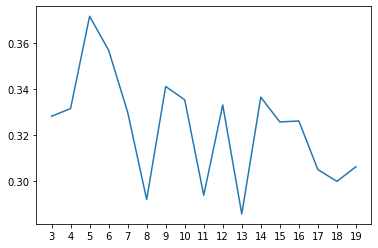

In [81]:
plt.plot(topics_nr, coherence_values_gensim)

In [89]:
# print topics for the different numbers of topics
for i in range(len(models_idx)):
  numtopics = models_idx[i]
  print('nr of topics: {}'.format(numtopics))
  model = models[i]
  topic_print = model.print_topics(num_words=30)
  df_topic_print = pd.DataFrame(topic_print, columns=['topic_id','words'])
  print(df_topic_print['words'])
  filename = '{}/num_topics_{}.csv'.format(output_folder,numtopics)
  df_topic_print.to_csv(filename)

nr of topics: 3
0    0.002*"pane" + 0.002*"domani" + 0.002*"miseria...
1    0.003*"partito" + 0.002*"socialista" + 0.002*"...
2    0.002*"polizia" + 0.002*"scioperanti" + 0.002*...
Name: words, dtype: object
nr of topics: 4
0    0.003*"dio" + 0.002*"società" + 0.002*"miseria...
1    0.002*"pane" + 0.002*"germania" + 0.002*"lynn"...
2    0.002*"sciopero" + 0.001*"polizia" + 0.001*"sc...
3    0.004*"partito" + 0.004*"socialista" + 0.003*"...
Name: words, dtype: object
nr of topics: 5
0    0.002*"pane" + 0.002*"domani" + 0.002*"dio" + ...
1    0.002*"germania" + 0.002*"mass" + 0.002*"lynn"...
2    0.004*"sciopero" + 0.003*"scioperanti" + 0.003...
3    0.003*"società" + 0.002*"anarchici" + 0.002*"p...
4    0.006*"socialista" + 0.006*"partito" + 0.003*"...
Name: words, dtype: object
nr of topics: 6
0    0.003*"sciopero" + 0.003*"scioperanti" + 0.002...
1    0.008*"partito" + 0.008*"socialista" + 0.005*"...
2    0.003*"società" + 0.002*"anarchici" + 0.002*"f...
3    0.002*"polizia" + 0.002*"

In [114]:
# select the model to display the rest of the steps by typing the desired number of topics below
numtopics = 5

In [117]:
idx = models_idx.index(numtopics)
model = models[idx]

# Topic visualisation

## Data Preparation

In [118]:
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py

--2020-07-23 10:39:00--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219774 (215K) [text/plain]
Saving to: ‘jscode-test-2.js.2’

jscode-test-2.js.2  100%[===================>] 214.62K  --.-KB/s    in 0.02s   

2020-07-23 10:39:00 (12.7 MB/s) - ‘jscode-test-2.js.2’ saved [219774/219774]

--2020-07-23 10:39:01--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent,

In [119]:
%%capture
!pip install funcy

In [120]:
%run -i tm1_data_prepare_gensim

In [121]:
data_vis = prepare(model, corpus, id2word, doc_topic_dist=None)

In [122]:
topic_info = data_vis[1][data_vis[1]['Category'] == 'Default'].copy()

In [123]:
topic_info['relevance'] = ''

In [124]:
for i in range(numtopics):
  topic_num = i+1
  data = data_vis.sorted_terms(topic=topic_num, _lambda=.6).copy()
  topic_info = topic_info.append(data)

In [ ]:
# uncomment to show the full output of a topic, replace 'Topic8' by the topic to display
# topic_info[topic_info['Category'] == 'Topic8']

In [125]:
topic_info.to_csv(output_folder + '/topic_info.csv')

In [126]:
topic_proportion = data_vis[0].copy()

In [127]:
topic_proportion['proportion'] = topic_proportion['Freq'] / 100

In [128]:
topic_proportion.index.name = 'topic_id'

In [129]:
topic_proportion.to_csv(output_folder + '/topic_proportion.csv')

In [130]:
# download also in Jupyter environment for further processing
topic_info.to_csv('topic_info.csv')
topic_proportion.to_csv('topic_proportion.csv')

In [131]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

## Visualisation

In [132]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [133]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [134]:
%%capture
ldamodel = model

In [135]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [136]:
distribution = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [137]:
distribution.index.name = 'document'

In [139]:
# add file names and publication name
distribution_wfiles = distribution.copy()
distribution_wfiles.insert(0, 'document_path', corpus_df['file_name'])
distribution_wfiles.insert(1, 'publication_name', corpus_df['publication_name'])
distribution_wfiles

,document_path,publication_name,topic0,topic1,topic2,topic3,topic4
document,,,,,,,
0,2012271201_1917-08-25_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000242,0.404062,0.000241,0.595214,0.000241
1,2012271201_1905-01-21_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000237,0.000237,0.000237,0.999054,0.000235
2,2012271201_1914-08-01_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000278,0.000278,0.174221,0.824945,0.000277
3,2012271201_1910-04-09_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.139635,0.000219,0.118704,0.420644,0.320798
4,2012271201_1917-10-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.639195,0.360071,0.000246,0.000245,0.000244
...,...,...,...,...,...,...,...
766,2012271201_1909-03-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000214,0.000213,0.622562,0.000214,0.376797
767,2012271201_1917-08-04_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000259,0.401111,0.000259,0.598113,0.000258
768,2012271201_1914-01-17_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.322661,0.279064,0.397676,0.000300,0.000299


## 3.2. Distribution per topic for the whole corpus

In [140]:
corpus_df['doc_length'] = corpus_df['doc_prep_nostop'].apply(lambda x: len(x))

In [141]:
topic_frequency = distribution.mul(corpus_df['doc_length'], axis=0).sum()

In [142]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [143]:
topic_proportion

topic3    39.556465
topic0    20.615973
topic1    20.432870
topic2    13.784099
topic4     5.610593
dtype: float64

In [144]:
# dataframe with values to sort them by order of importance
distribution_df = pd.DataFrame(topic_proportion, columns=['weight'])

In [145]:
distribution_df.index.name = "topics"

In [146]:
distribution_df.to_csv(output_folder + '/topic_distribution.csv')

In [147]:
topics = distribution_df.index.array

Text(0.5, 0, 'Weight (%)')

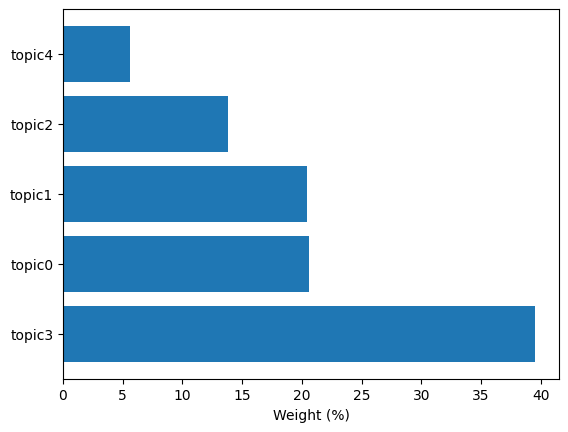

In [148]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df['weight'], align='center')
ax.set_xlabel('Weight (%)')

### 3.3. Distribution per publication


In [149]:
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [150]:
groupby2 = distribution_wfiles.copy()

In [151]:
distribution_title = groupby2.groupby(['publication_name']).mean().reset_index()
#distribution_title['publication'] = distribution_title['publication'].apply(lambda x: get_pub_name(x))

In [152]:
distribution_title

,publication_name,topic0,topic1,topic2,topic3,topic4
0,Cronaca Sovversiva,0.201263,0.181375,0.131964,0.421191,0.064208


In [153]:
distribution_title.to_csv(output_folder + '/distribution_per_publication.csv')

In [154]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication_name'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

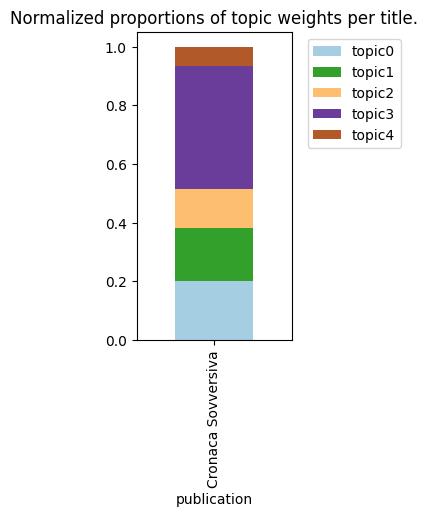

In [155]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time

## 4.1 Aggregate document weights

In [ ]:
# grouping data per month

In [156]:
distribution_wfiles['date'] = distribution_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_wfiles['year'] = distribution_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_wfiles['month'] = distribution_wfiles['document_path'].apply(lambda x: get_month(x))

In [157]:
groupby = distribution_wfiles.copy()

In [158]:
# drop columns that won't be needed at this stage
groupby = groupby.drop(['document_path', 'date'], axis=1)

In [159]:
# group by year 
distribution_year = groupby.groupby(['year']).mean().reset_index()

In [160]:
distribution_year

,year,topic0,topic1,topic2,topic3,topic4
0,1903,0.192702,0.009946,0.059493,0.708957,0.028902
1,1904,0.190738,0.013655,0.100158,0.636850,0.058598
2,1905,0.125795,0.015228,0.063550,0.640027,0.155400
3,1906,0.070050,0.011534,0.050658,0.697405,0.170353
4,1907,0.148348,0.041730,0.075789,0.573225,0.160908
5,1908,0.204275,0.046593,0.194188,0.483125,0.071820
6,1909,0.233580,0.107676,0.185733,0.301658,0.171353
7,1910,0.167514,0.083393,0.230204,0.480494,0.038394
8,1911,0.118093,0.139175,0.100603,0.624980,0.017149
9,1912,0.154680,0.186456,0.384490,0.255050,0.019323


In [161]:
distribution_year.to_csv(output_folder + '/distribution_per_year.csv')


## 4.2 Yearly average of normalized weight per topic

### 4.2.1. Line chart view 

In [169]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_year.columns)-1
for i in range(len(distribution_year)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_year['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_year.columns[j+1]
    df_vis['distribution'].loc[x] = distribution_year.iloc[i,(j+1)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


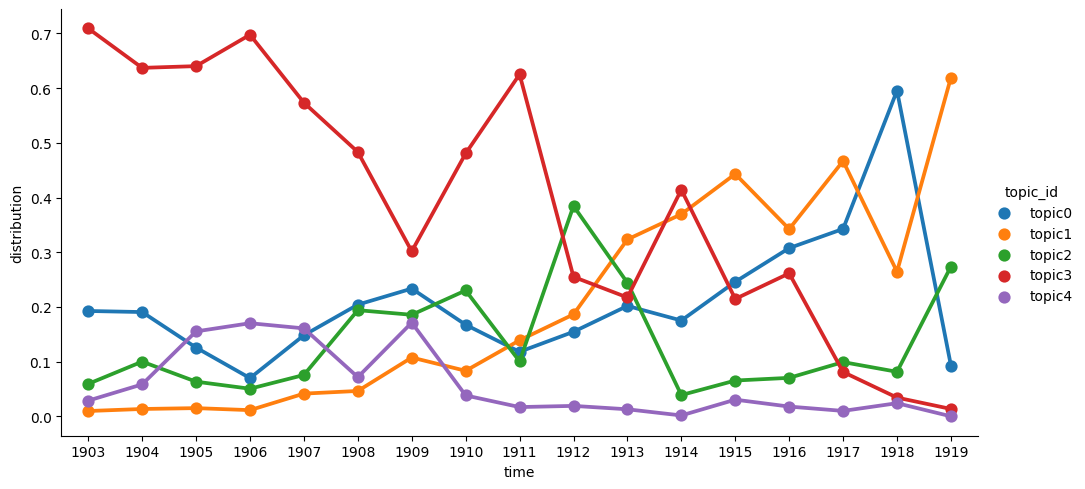

In [170]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.2. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


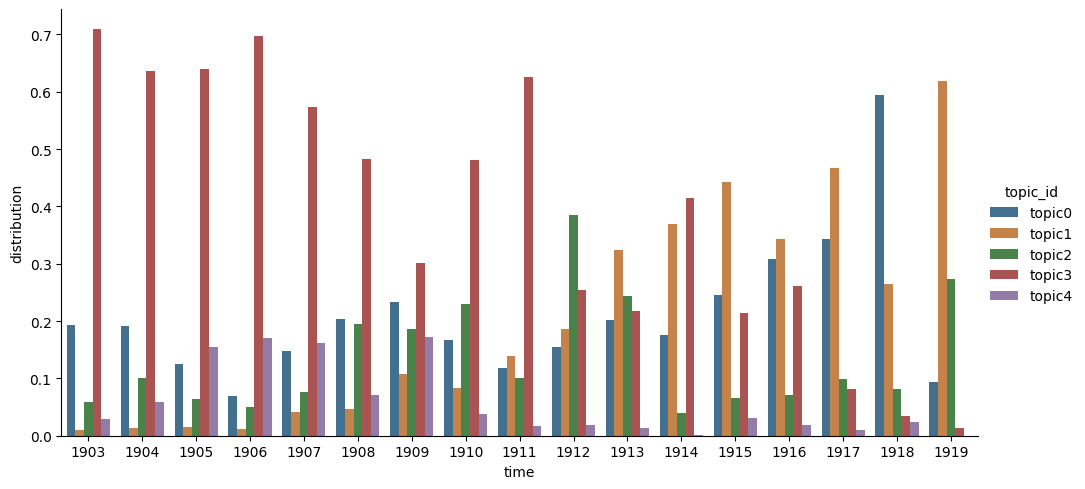

In [171]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Topic weights per title over time



In [172]:
groupby3 = distribution_wfiles.copy()

In [173]:
distribution_title_time = groupby3.groupby(['year','publication_name']).mean().reset_index()

In [174]:
distribution_title_time

,year,publication_name,topic0,topic1,topic2,topic3,topic4
0,1903,Cronaca Sovversiva,0.192702,0.009946,0.059493,0.708957,0.028902
1,1904,Cronaca Sovversiva,0.190738,0.013655,0.100158,0.636850,0.058598
2,1905,Cronaca Sovversiva,0.125795,0.015228,0.063550,0.640027,0.155400
3,1906,Cronaca Sovversiva,0.070050,0.011534,0.050658,0.697405,0.170353
4,1907,Cronaca Sovversiva,0.148348,0.041730,0.075789,0.573225,0.160908
5,1908,Cronaca Sovversiva,0.204275,0.046593,0.194188,0.483125,0.071820
6,1909,Cronaca Sovversiva,0.233580,0.107676,0.185733,0.301658,0.171353
7,1910,Cronaca Sovversiva,0.167514,0.083393,0.230204,0.480494,0.038394
8,1911,Cronaca Sovversiva,0.118093,0.139175,0.100603,0.624980,0.017149
9,1912,Cronaca Sovversiva,0.154680,0.186456,0.384490,0.255050,0.019323


In [175]:
distribution_title_time.to_csv(output_folder + 'distribution_per_publication_over_time.csv')

### 4.2.4. Rolling average

#### 4.2.4.1. Rolling average by topic

In [176]:
rolling_mean = distribution_year.rolling(2).mean()

In [177]:
rolling_mean.to_csv(output_folder + 'rolling_mean.csv')

In [187]:
#restructuring df so that it can work with seaborn
df_vis3 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean.columns)-1
for i in range(len(rolling_mean)):
  for j in range(columns_nr):
    if ( rolling_mean.iloc[i,(j+1)] > 0 ):
      df_vis3.loc[x] = ''
      df_vis3['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis3['topic_id'].loc[x] = rolling_mean.columns[j+1]
      df_vis3['rolling_mean'].loc[x] = rolling_mean.iloc[i,(j+1)]
      x+= 1

In [197]:
df_vis3

,time,topic_id,rolling_mean
0,1904,topic0,0.19172
1,1904,topic1,0.011801
2,1904,topic2,0.0798256
3,1904,topic3,0.672904
4,1904,topic4,0.0437497
...,...,...,...
75,1919,topic0,0.344114
76,1919,topic1,0.441821
77,1919,topic2,0.17774
78,1919,topic3,0.0240797


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


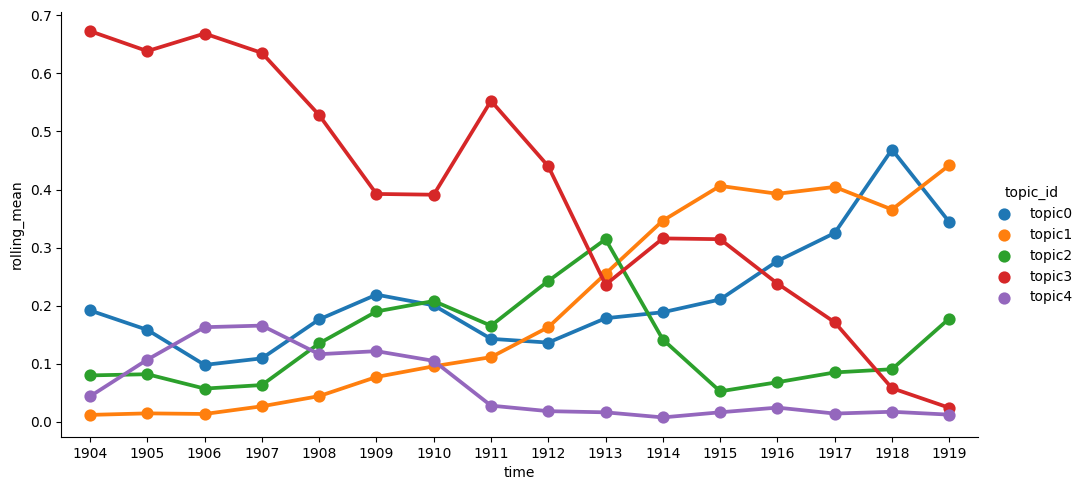

In [188]:
sns.factorplot(data= df_vis3, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

#### 4.2.4.1. Rolling average by publication

In [ ]:
# Filtering the distribution over time by publication
# in the cell below replace 'Cronaca Sovversiva' by the publication to display
# and for the output file, each time the filter is applied on a publication, change the output file name

In [180]:
distribution_publication_time = distribution_title_time[distribution_title_time['publication_name'] == 'Cronaca Sovversiva']

In [181]:
rolling_mean_publication = distribution_publication_time.rolling(2).mean()

In [182]:
rolling_mean_publication.to_csv(output_folder + 'rolling_mean_cronaca_sovversiva.csv')

In [194]:
#restructuring df so that it can work with seaborn
df_vis4 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean_publication.columns)
for i in range(len(rolling_mean_publication)):
  for j in range(columns_nr):
    if ( rolling_mean_publication.iloc[i,(j)] > 0 ):
      df_vis4.loc[x] = ''
      df_vis4['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis4['topic_id'].loc[x] = rolling_mean_publication.columns[j]
      df_vis4['rolling_mean'].loc[x] = rolling_mean_publication.iloc[i,(j)]
      x+= 1

In [196]:
df_vis4

,time,topic_id,rolling_mean
0,1904,topic0,0.19172
1,1904,topic1,0.011801
2,1904,topic2,0.0798256
3,1904,topic3,0.672904
4,1904,topic4,0.0437497
...,...,...,...
75,1919,topic0,0.344114
76,1919,topic1,0.441821
77,1919,topic2,0.17774
78,1919,topic3,0.0240797


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


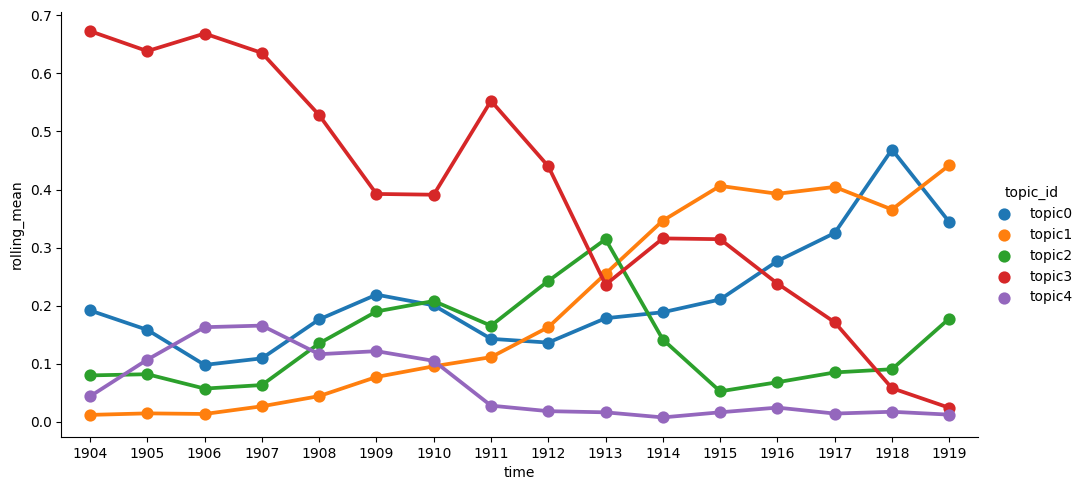

In [195]:
sns.factorplot(data= df_vis4, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)